In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
from collections import deque

In [2]:
def cal_clust_silhouette(adata, n_pcs, resolution):
    tmp_adata = sc.pp.neighbors(adata, n_pcs=n_pcs, copy=True)
    sc.tl.umap(tmp_adata)
    sc.tl.leiden(tmp_adata, key_added="leiden_res", resolution=resolution)
    return silhouette_score(tmp_adata.X, tmp_adata.obs['leiden_res'])

# read in data

In [2]:
adata = sc.read_10x_h5('../../20231103_Aedes_midgut.2sp_rerun/1.cellranger_count/map_2022_Aaedes_midgut/outs/filtered_feature_bc_matrix.h5')

adata.var_names_make_unique()
adata

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


AnnData object with n_obs × n_vars = 12049 × 19804
    var: 'gene_ids', 'feature_types', 'genome'

# QC

## mark mitochondrial genes

In [3]:
# mitochondrial genes
mt_genes = ("AAEL018658", "AAEL018659", "AAEL018660", "AAEL018661", "AAEL018662", "AAEL018663", "AAEL018664", "AAEL018665", "AAEL018666", "AAEL018667", "AAEL018668", "AAEL018669", "AAEL018670", "AAEL018671", "AAEL018672", "AAEL018673", "AAEL018674", "AAEL018675", "AAEL018676", "AAEL018677", "AAEL018678", "AAEL018679", "AAEL018680", "AAEL018681", "AAEL018682", "AAEL018683", "AAEL018684", "AAEL018685", "AAEL018686", "AAEL018687", "AAEL018688", "AAEL018689", "AAEL018690", "AAEL018691", "AAEL018692", "AAEL018693", "AAEL018694", "AAEL020667")

adata.var["mt"] = adata.var_names.map(lambda x: str(x) in mt_genes)

## calculate QC metrics

In [4]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[100], log1p=False
)
adata

AnnData object with n_obs × n_vars = 12049 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [5]:
adata.obs['pct_counts_mt'].median()

35.439137

## plot QC plot before do filtering 

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categ

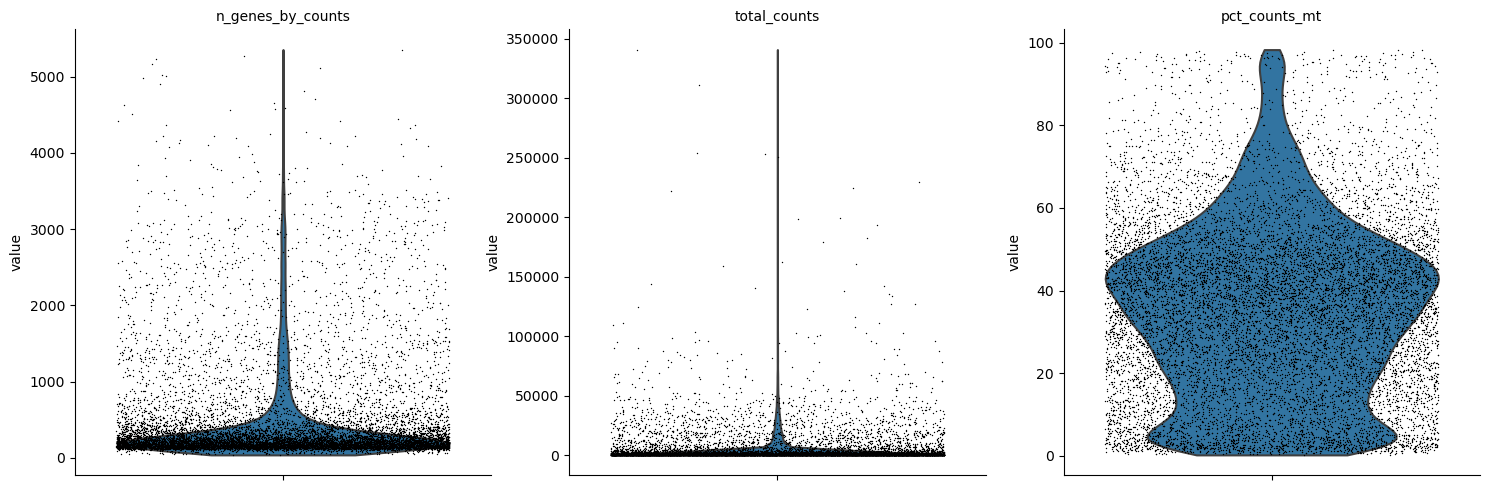

In [6]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

## plot QC plot after do filtering 

In [7]:
# QC thresholds
min_n_genes_by_counts = 100
# maximum nFeature_RNA
max_n_genes_by_counts = 2500
# maximum percent.mt
max_percent_mt = 30

adata = adata[
    (adata.obs.n_genes_by_counts > min_n_genes_by_counts) & \
    (adata.obs.n_genes_by_counts < max_n_genes_by_counts), :]
adata = adata[adata.obs.pct_counts_mt < max_percent_mt, :].copy()

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure 

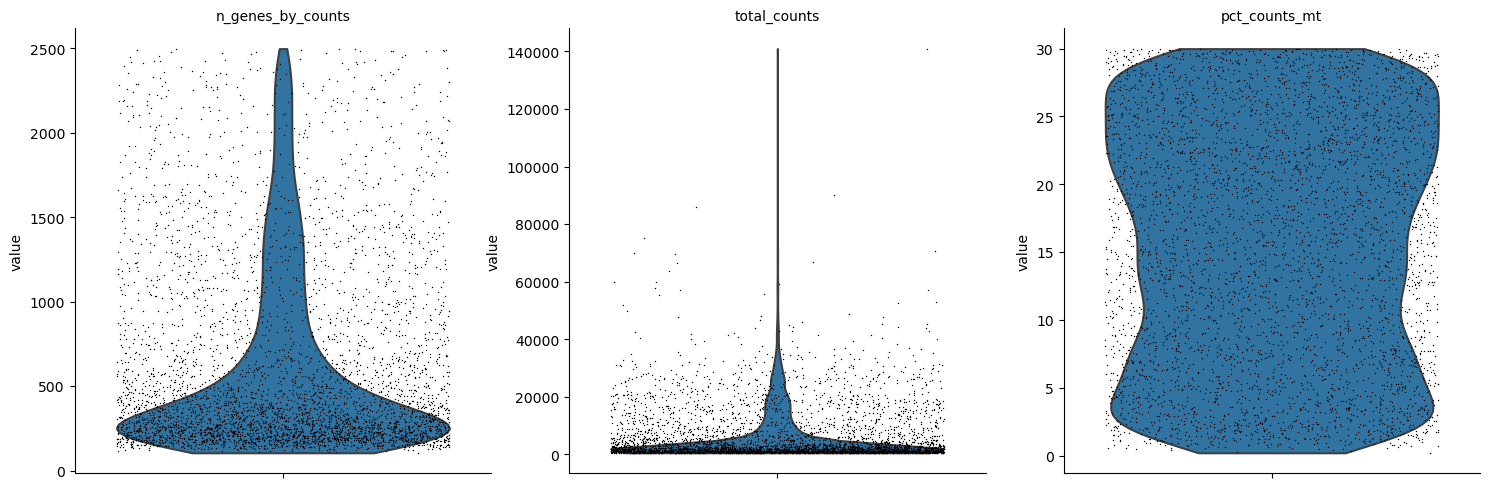

In [8]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

## remove doublets

In [9]:
# read in data marked doublets
dblets = sc.read('./mark_doublet/mark_doublet.seurat_obj.h5ad')
dblets

AnnData object with n_obs × n_vars = 4531 × 11663
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'pANN_0.25_0.09_181', 'DF.classifications_0.25_0.09_181'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [10]:
# remove doublets
dblets_col = [i for i in dblets.obs.columns if i.startswith('DF.classifications_')][0]
sglets_obs = dblets.obs[dblets.obs[dblets_col] == 'Singlet'].index
adata = adata[adata.obs.index.isin(sglets_obs)]
adata

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


View of AnnData object with n_obs × n_vars = 4350 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## save AnnData after QC

In [11]:
# save data
adata.write("1.QC.h5ad")
# show AnnData
adata

View of AnnData object with n_obs × n_vars = 4350 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Normalization

In [12]:
# read in data
adata = sc.read('./1.QC.h5ad')
adata

AnnData object with n_obs × n_vars = 4350 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [13]:
# normalization 
sc.pp.normalize_total(adata)
# Logarithmize
sc.pp.log1p(adata)
# show AnnData
adata

AnnData object with n_obs × n_vars = 4350 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [14]:
# save data
adata.write("2.normalization.h5ad")

# Feature Selection

In [15]:
# read in data
adata = sc.read('./2.normalization.h5ad')
adata

AnnData object with n_obs × n_vars = 4350 × 19804
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [16]:
# find highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor='seurat_v3')
# save original AnnData to `.raw` attribute
adata.raw = adata
# only keeping highly variable genes in AnnData
adata = adata[:, adata.var.highly_variable]
# scale each gene to unit variance
sc.pp.scale(adata)
# show AnnData
adata

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 4350 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [17]:
# save data
adata.write("3.after_feature_selection.h5ad")

# dimensional reduction

In [18]:
# read in data
adata = sc.read('./3.after_feature_selection.h5ad')
adata

AnnData object with n_obs × n_vars = 4350 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


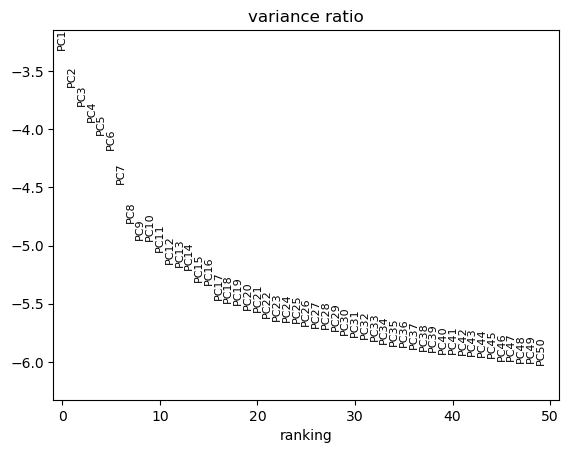

In [19]:
# run PCA
sc.pp.pca(adata, svd_solver="arpack", use_highly_variable=True)
# plot single PCs to the total variance in the data
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

In [20]:
# save data
adata.write("4.PCA.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 4350 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

# clustering

In [21]:
# read in data
adata = sc.read('./4.PCA.h5ad')
adata

AnnData object with n_obs × n_vars = 4350 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## arguments selection

In [23]:
args_res = deque()
all_pcs = np.linspace(17, 22, 6).astype(int)
all_reses = np.linspace(0.1, 0.9, 5)

count = 0
total_process = len(all_pcs) * len(all_reses)
for pcs in all_pcs:
    for res in all_reses:
        count += 1

        sil = cal_clust_silhouette(adata, pcs, res)
        args_res.append([pcs, res, sil])

        if count % 3 == 0:
            print(f'Processing {count}/{total_process}')
        
args_res_df = pd.DataFrame(args_res, columns=['n_pcs', 'resolution', 'silhouette_score'])

Processing 3/30
Processing 6/30
Processing 9/30
Processing 12/30
Processing 15/30
Processing 18/30
Processing 21/30
Processing 24/30
Processing 27/30
Processing 30/30


In [24]:
best_args = args_res_df[args_res_df['silhouette_score'] == args_res_df['silhouette_score'].max()]
best_args

,n_pcs,resolution,silhouette_score
20,21,0.1,-0.006657


In [25]:
args_res_df.to_csv('./5.arg_select.csv', index=False)

## plot UMAP

/tmp/ipykernel_19425/3086038833.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  adata = sc.pp.neighbors(adata, n_pcs=int(best_args['n_pcs']), copy=True)
/tmp/ipykernel_19425/3086038833.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sc.tl.leiden(adata, key_added="leiden_res", resolution=float(best_args['resolution']))
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `

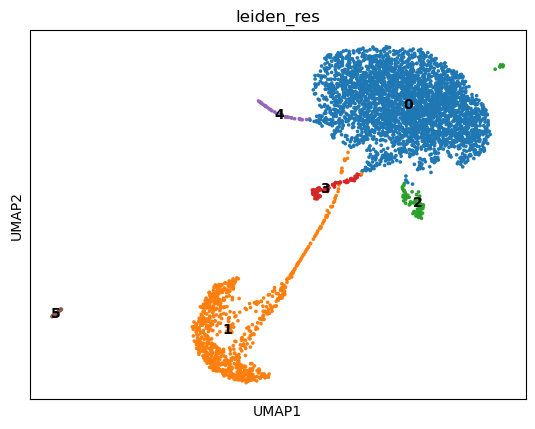

In [26]:
adata = sc.pp.neighbors(adata, n_pcs=int(best_args['n_pcs']), copy=True)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_res", resolution=float(best_args['resolution']))

sc.pl.umap(
    adata,
    color=["leiden_res"],
    legend_loc="on data",
)

In [27]:
adata.obs['leiden_res'].value_counts()

leiden_res
0    3354
1     772
2      83
3      78
4      40
5      23
Name: count, dtype: int64

In [28]:
# save data
adata.write("5.cluster.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 4350 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_res_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Annotation

In [2]:
# read in data
adata = sc.read('./5.cluster.h5ad')
adata

AnnData object with n_obs × n_vars = 4350 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_res_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## make marker genes dict

In [3]:
marker_genes = {
    'ISC/EB': ['AAEL013544', 'AAEL025606'], # Klu, Delta
    'Cardia': ['AAEL004522'], # gambicin
    'EC-like': ['AAEL008769', 'AAEL009330'], # SP24D, AeCA  # ['AAEL007818', 'AAEL001863'], # trypsin 3A1, Carboxypeptidase
    'EC': ['AAEL017445'], # Nubbin
    'EE': ['AAEL002769', 'AAEL002733'], # prospero, NPF
    'VM': ['AAEL001673'], # Actin
    'FBC': ['AAEL008789'], # apoLp-III 'https://www.science.org/doi/10.1126/science.abc0322#supplementary-materials' (table s5)
    'HC': ['AAEL008658'], # LRIM16
    'Midgut marker gene': ['AAEL001863'],
}

## plot marker genes on UMAP

/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:770: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[groupby]):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/public21/home/sc90258/miniconda3/envs/hy-seurat/lib/python3.11/site-packages/seaborn/categorical.py:641: F

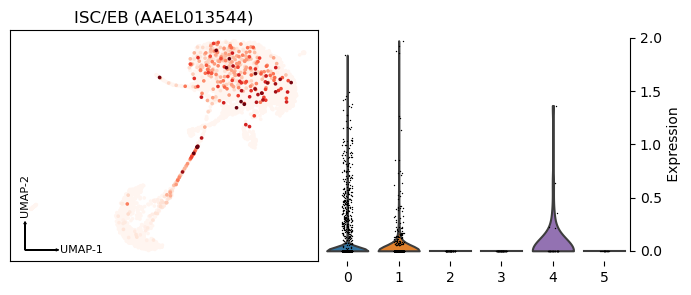

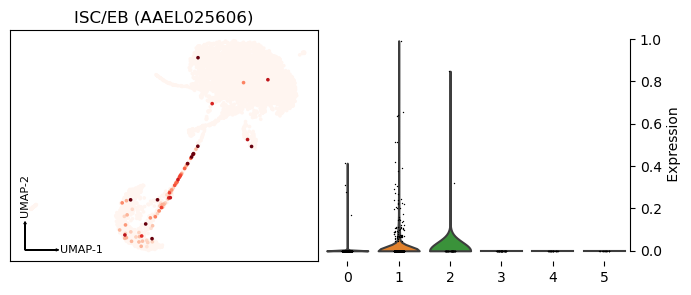

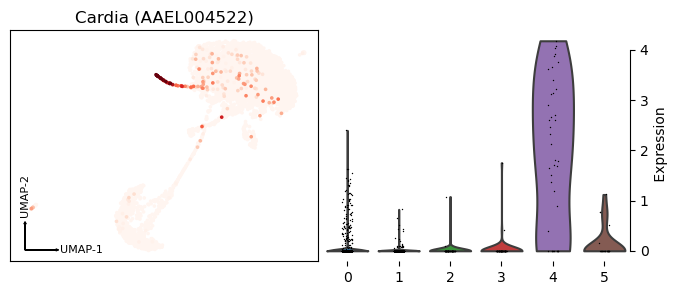

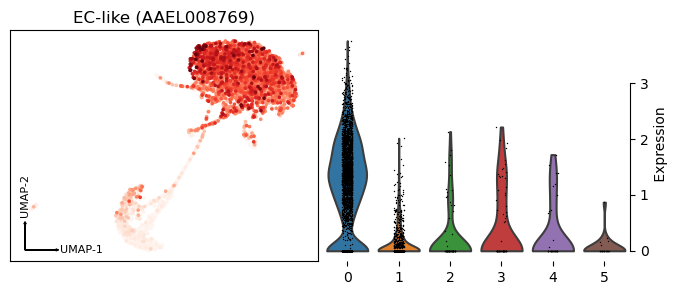

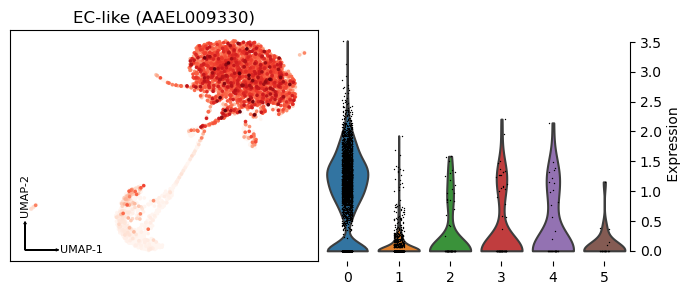

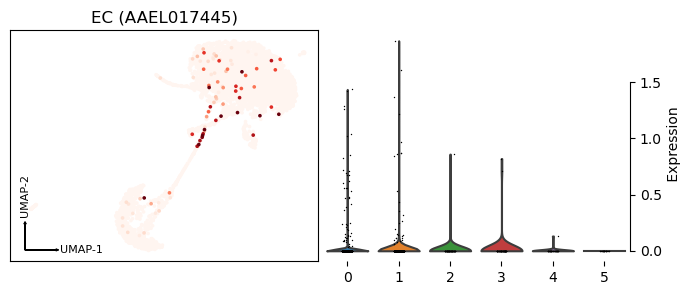

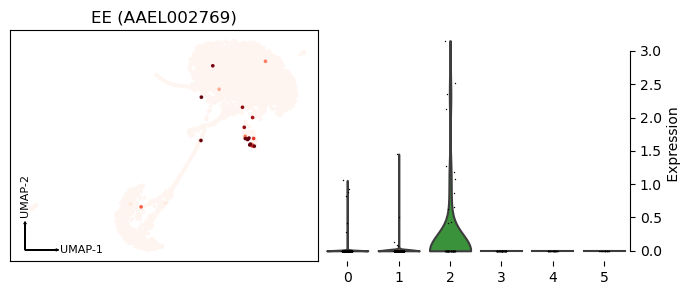

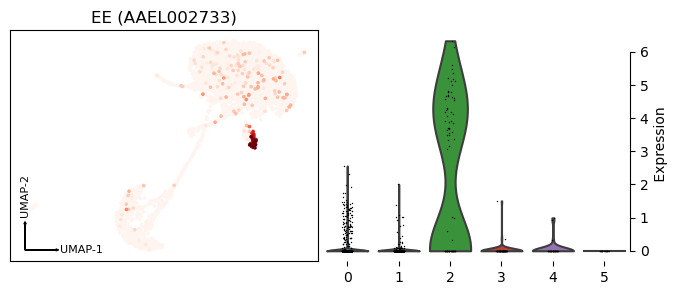

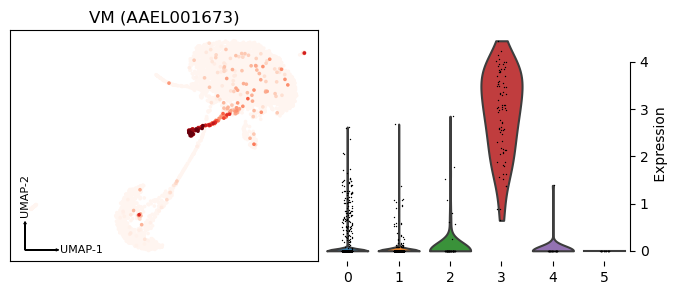

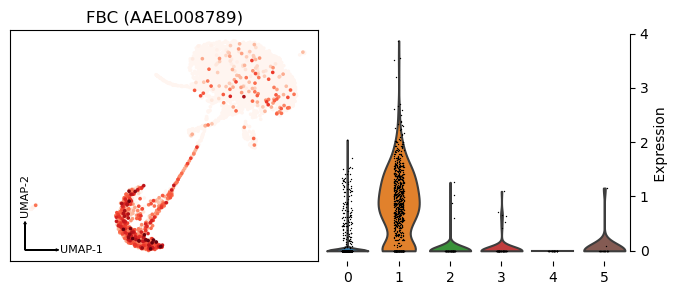

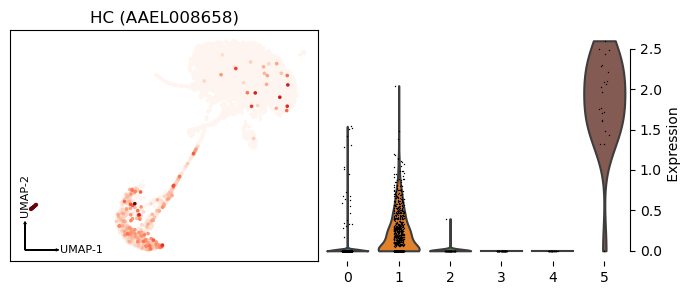

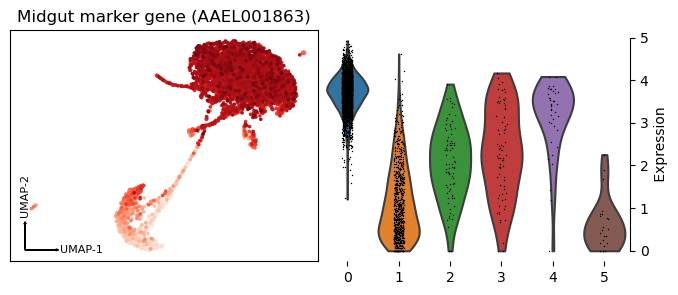

In [4]:
def plot_umap_violin_rep(adata, marker, cluster):

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig = plt.figure(figsize=(8, 3))

    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    sc.pl.umap(
        adata,
        color=marker,
        vmax='p99.8',
        vmin=0,
        frameon=True,
        cmap="Reds",
        colorbar_loc=None,
        title=f'{cluster} ({marker})',
        ax=ax1, show=False
    )

    ax1.arrow(
        -6.5, -3, 0, 3, 
        width=0.01, head_width=0.2, overhang=0.3, 
        color='k', zorder=10)
    ax1.arrow(
        -6.5, -3, 3, 0, 
        width=0.01, head_width=0.2, overhang=0.3,
        color='k', zorder=10)

    ax1.text(-3.1, -3, 'UMAP-1', ha='left', va='center', fontsize=8)
    ax1.text(-6.5, 0.8, 'UMAP-2', ha='center', va='bottom', rotation=90, fontsize=8)

    # ax1.set_title('')
    ax1.set_xlabel('')
    ax1.set_ylabel('')

    # ax1.set_xlim(-7.5, 21)
    # ax1.set_ylim(-3.6, 16)

    sc.pl.violin(
        adata,
        marker,
        groupby='leiden_res',
        ax=ax2, show=False
    )

    ax2.set_xlabel('')

    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel(' Expression')
    ax2.tick_params(axis='y', right=True)
    sns.despine(top=True, bottom=True, left=True, right=False, trim=1, ax=ax2)

    # plot title
    # ax1.plot((-6.5, 50), (19,19), '-k', clip_on=False, zorder=100)
    # ax1.text((-6.5 + 50) / 2, 19.2, f'{cluster} ({marker})', ha='center', va='bottom')

    plt.subplots_adjust(
        hspace=0.3, wspace=0.01)

for cluster in marker_genes.keys():
    for marker in marker_genes[cluster]:

        plot_umap_violin_rep(
            adata, marker, cluster, 
        )

In [33]:
# save data
adata.write("6.Annotation.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 4350 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_100_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden_res'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_res_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'